In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import mode
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

In [2]:
cinic_directory = 'C:/Users/Dell/.cache/kagglehub/datasets/mengcius/cinic10/versions/1'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform_augment_advanced = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

transform_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform_rotation = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform_colorJitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std)
])

transform_cutOut = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cinic_mean, std=cinic_std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

cinic_train = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform),
    batch_size=128, shuffle=True)
cinic_valid = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/valid', transform=transform),
    batch_size=128, shuffle=False)

cinic_train_augment = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_augment),
    batch_size=128, shuffle=True)
cinic_train_crop = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_crop),
    batch_size=128, shuffle=True)
cinic_train_flip = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_flip),
    batch_size=128, shuffle=True)
cinic_train_rotation = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_rotation),
    batch_size=128, shuffle=True)
cinic_train_colorJitter = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_colorJitter),
    batch_size=128, shuffle=True)
cinic_train_augment_advanced = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_augment_advanced),
    batch_size=128, shuffle=True)
cinic_train_cutOut = DataLoader(
    torchvision.datasets.ImageFolder(cinic_directory + '/train', transform=transform_cutOut),
    batch_size=128, shuffle=True)

torch.Size([3, 32, 32])


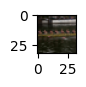

Etykieta: 8


In [3]:
cinic_mean_tensor = torch.tensor(cinic_mean).view(3, 1, 1)
cinic_std_tensor = torch.tensor(cinic_std).view(3, 1, 1)


def imshow(img):
    print(img.size())
    img = img * cinic_std_tensor + cinic_mean_tensor  # Odwracamy normalizację
    npimg = img.numpy()
    plt.figure(figsize=(0.5, 0.5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


data_iter = iter(cinic_train)
images, labels = next(data_iter)

imshow(images[0])
print("Etykieta:", labels[0].item())

In [4]:
def train(model, device, cinic_train, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_tqdm = tqdm(cinic_train, desc=f"Epoka {epoch + 1}/{num_epochs}")

        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(cinic_train)
        accuracy = 100 * correct / total
        print(f"Epoka [{epoch + 1}/{num_epochs}], Strata: {avg_loss:.4f}, Dokładność: {accuracy:.2f}%")

    print("Trenowanie zakończone!")

In [5]:
def test(model, device, cinic_valid):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in cinic_valid:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Dokładność na zbiorze walidacyjnym: {100 * correct / total:.2f}%")

### Simple Fully Connected NN

In [24]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
model_crop = SimpleNN().to(device)
model_flip = SimpleNN().to(device)
model_rotate = SimpleNN().to(device)
model_colorJitter = SimpleNN().to(device)
model_augmentation = SimpleNN().to(device)
train(model, device, cinic_train)
train(model_crop, device, cinic_train_crop)
train(model_flip, device, cinic_train_flip)
train(model_rotate, device, cinic_train_rotation)
train(model_colorJitter, device, cinic_train_colorJitter)
train(model_augmentation, device, cinic_train_augment)


Epoka 1/10: 100%|██████████| 704/704 [00:57<00:00, 12.30it/s, loss=1.73]


Epoka [1/10], Strata: 1.9092, Dokładność: 30.61%


Epoka 2/10: 100%|██████████| 704/704 [00:56<00:00, 12.48it/s, loss=1.57]


Epoka [2/10], Strata: 1.7786, Dokładność: 35.73%


Epoka 3/10: 100%|██████████| 704/704 [01:05<00:00, 10.70it/s, loss=1.86]


Epoka [3/10], Strata: 1.7245, Dokładność: 37.84%


Epoka 4/10: 100%|██████████| 704/704 [00:57<00:00, 12.22it/s, loss=1.46]


Epoka [4/10], Strata: 1.6868, Dokładność: 39.45%


Epoka 5/10: 100%|██████████| 704/704 [00:44<00:00, 15.78it/s, loss=1.69]


Epoka [5/10], Strata: 1.6590, Dokładność: 40.52%


Epoka 6/10: 100%|██████████| 704/704 [00:45<00:00, 15.52it/s, loss=1.4] 


Epoka [6/10], Strata: 1.6361, Dokładność: 41.28%


Epoka 7/10: 100%|██████████| 704/704 [00:46<00:00, 15.04it/s, loss=1.49]


Epoka [7/10], Strata: 1.6136, Dokładność: 42.12%


Epoka 8/10: 100%|██████████| 704/704 [00:43<00:00, 16.15it/s, loss=1.46]


Epoka [8/10], Strata: 1.5950, Dokładność: 42.90%


Epoka 9/10: 100%|██████████| 704/704 [00:44<00:00, 15.96it/s, loss=1.33]


Epoka [9/10], Strata: 1.5782, Dokładność: 43.63%


Epoka 10/10: 100%|██████████| 704/704 [00:43<00:00, 16.11it/s, loss=1.47]


Epoka [10/10], Strata: 1.5657, Dokładność: 44.16%
Trenowanie zakończone!


Epoka 1/10: 100%|██████████| 704/704 [00:51<00:00, 13.69it/s, loss=1.82]


Epoka [1/10], Strata: 1.9984, Dokładność: 26.20%


Epoka 2/10: 100%|██████████| 704/704 [00:52<00:00, 13.33it/s, loss=1.71]


Epoka [2/10], Strata: 1.8888, Dokładność: 30.82%


Epoka 3/10: 100%|██████████| 704/704 [00:50<00:00, 13.88it/s, loss=1.97]


Epoka [3/10], Strata: 1.8456, Dokładność: 32.62%


Epoka 4/10: 100%|██████████| 704/704 [00:51<00:00, 13.63it/s, loss=2.38]


Epoka [4/10], Strata: 1.8148, Dokładność: 33.94%


Epoka 5/10: 100%|██████████| 704/704 [00:53<00:00, 13.27it/s, loss=1.9] 


Epoka [5/10], Strata: 1.7894, Dokładność: 34.91%


Epoka 6/10: 100%|██████████| 704/704 [01:27<00:00,  8.04it/s, loss=2.07]


Epoka [6/10], Strata: 1.7740, Dokładność: 35.53%


Epoka 7/10: 100%|██████████| 704/704 [01:33<00:00,  7.56it/s, loss=2.03]


Epoka [7/10], Strata: 1.7570, Dokładność: 36.07%


Epoka 8/10: 100%|██████████| 704/704 [01:25<00:00,  8.28it/s, loss=1.62]


Epoka [8/10], Strata: 1.7469, Dokładność: 36.40%


Epoka 9/10: 100%|██████████| 704/704 [00:51<00:00, 13.60it/s, loss=1.83]


Epoka [9/10], Strata: 1.7364, Dokładność: 36.85%


Epoka 10/10: 100%|██████████| 704/704 [00:51<00:00, 13.59it/s, loss=1.46]


Epoka [10/10], Strata: 1.7293, Dokładność: 37.04%
Trenowanie zakończone!


Epoka 1/10: 100%|██████████| 704/704 [00:48<00:00, 14.41it/s, loss=1.59]


Epoka [1/10], Strata: 1.9077, Dokładność: 30.81%


Epoka 2/10: 100%|██████████| 704/704 [01:19<00:00,  8.87it/s, loss=1.78]


Epoka [2/10], Strata: 1.7861, Dokładność: 35.40%


Epoka 3/10: 100%|██████████| 704/704 [01:20<00:00,  8.69it/s, loss=1.28]


Epoka [3/10], Strata: 1.7344, Dokładność: 37.57%


Epoka 4/10: 100%|██████████| 704/704 [01:27<00:00,  8.03it/s, loss=2.04]


Epoka [4/10], Strata: 1.7032, Dokładność: 38.73%


Epoka 5/10: 100%|██████████| 704/704 [01:30<00:00,  7.81it/s, loss=1.43]


Epoka [5/10], Strata: 1.6772, Dokładność: 39.77%


Epoka 6/10: 100%|██████████| 704/704 [01:24<00:00,  8.29it/s, loss=1.71]


Epoka [6/10], Strata: 1.6574, Dokładność: 40.67%


Epoka 7/10: 100%|██████████| 704/704 [00:46<00:00, 15.16it/s, loss=1.66]


Epoka [7/10], Strata: 1.6391, Dokładność: 41.24%


Epoka 8/10: 100%|██████████| 704/704 [00:47<00:00, 14.75it/s, loss=1.44]


Epoka [8/10], Strata: 1.6249, Dokładność: 41.74%


Epoka 9/10: 100%|██████████| 704/704 [00:47<00:00, 14.67it/s, loss=2.44]


Epoka [9/10], Strata: 1.6136, Dokładność: 42.20%


Epoka 10/10: 100%|██████████| 704/704 [00:47<00:00, 14.97it/s, loss=1.43]


Epoka [10/10], Strata: 1.5987, Dokładność: 42.76%
Trenowanie zakończone!


Epoka 1/10: 100%|██████████| 704/704 [00:51<00:00, 13.70it/s, loss=1.84]


Epoka [1/10], Strata: 1.9265, Dokładność: 29.62%


Epoka 2/10: 100%|██████████| 704/704 [00:56<00:00, 12.42it/s, loss=1.83]


Epoka [2/10], Strata: 1.8052, Dokładność: 34.74%


Epoka 3/10: 100%|██████████| 704/704 [00:55<00:00, 12.59it/s, loss=1.48]


Epoka [3/10], Strata: 1.7563, Dokładność: 36.66%


Epoka 4/10: 100%|██████████| 704/704 [00:49<00:00, 14.21it/s, loss=1.92]


Epoka [4/10], Strata: 1.7240, Dokładność: 37.90%


Epoka 5/10: 100%|██████████| 704/704 [00:48<00:00, 14.38it/s, loss=1.94]


Epoka [5/10], Strata: 1.6996, Dokładność: 38.77%


Epoka 6/10: 100%|██████████| 704/704 [00:50<00:00, 14.02it/s, loss=1.54]


Epoka [6/10], Strata: 1.6802, Dokładność: 39.54%


Epoka 7/10: 100%|██████████| 704/704 [00:49<00:00, 14.10it/s, loss=1.57]


Epoka [7/10], Strata: 1.6634, Dokładność: 40.24%


Epoka 8/10: 100%|██████████| 704/704 [00:51<00:00, 13.68it/s, loss=1.67]


Epoka [8/10], Strata: 1.6473, Dokładność: 40.54%


Epoka 9/10: 100%|██████████| 704/704 [00:50<00:00, 14.00it/s, loss=1.51]


Epoka [9/10], Strata: 1.6371, Dokładność: 40.95%


Epoka 10/10: 100%|██████████| 704/704 [00:49<00:00, 14.20it/s, loss=1.57]


Epoka [10/10], Strata: 1.6252, Dokładność: 41.34%
Trenowanie zakończone!


Epoka 1/10: 100%|██████████| 704/704 [01:01<00:00, 11.43it/s, loss=1.89]


Epoka [1/10], Strata: 1.9209, Dokładność: 30.36%


Epoka 2/10: 100%|██████████| 704/704 [01:04<00:00, 10.97it/s, loss=1.5] 


Epoka [2/10], Strata: 1.7938, Dokładność: 35.26%


Epoka 3/10: 100%|██████████| 704/704 [01:02<00:00, 11.26it/s, loss=1.71]


Epoka [3/10], Strata: 1.7407, Dokładność: 37.38%


Epoka 4/10: 100%|██████████| 704/704 [01:03<00:00, 11.16it/s, loss=2.28]


Epoka [4/10], Strata: 1.7024, Dokładność: 38.78%


Epoka 5/10: 100%|██████████| 704/704 [01:05<00:00, 10.70it/s, loss=1.74]


Epoka [5/10], Strata: 1.6757, Dokładność: 39.99%


Epoka 6/10: 100%|██████████| 704/704 [01:04<00:00, 10.94it/s, loss=1.73]


Epoka [6/10], Strata: 1.6520, Dokładność: 40.86%


Epoka 7/10: 100%|██████████| 704/704 [01:02<00:00, 11.33it/s, loss=1.71]


Epoka [7/10], Strata: 1.6341, Dokładność: 41.46%


Epoka 8/10: 100%|██████████| 704/704 [01:03<00:00, 11.09it/s, loss=2.05]


Epoka [8/10], Strata: 1.6146, Dokładność: 42.36%


Epoka 9/10: 100%|██████████| 704/704 [01:00<00:00, 11.72it/s, loss=1.68]


Epoka [9/10], Strata: 1.5994, Dokładność: 42.80%


Epoka 10/10: 100%|██████████| 704/704 [01:00<00:00, 11.70it/s, loss=1.4] 


Epoka [10/10], Strata: 1.5816, Dokładność: 43.49%
Trenowanie zakończone!


Epoka 1/10: 100%|██████████| 704/704 [01:14<00:00,  9.49it/s, loss=1.63]


Epoka [1/10], Strata: 2.0177, Dokładność: 25.37%


Epoka 2/10: 100%|██████████| 704/704 [01:13<00:00,  9.51it/s, loss=2.18]


Epoka [2/10], Strata: 1.9179, Dokładność: 29.86%


Epoka 3/10: 100%|██████████| 704/704 [01:13<00:00,  9.58it/s, loss=1.99]


Epoka [3/10], Strata: 1.8751, Dokładność: 31.42%


Epoka 4/10: 100%|██████████| 704/704 [01:13<00:00,  9.62it/s, loss=1.85]


Epoka [4/10], Strata: 1.8470, Dokładność: 32.65%


Epoka 5/10: 100%|██████████| 704/704 [01:13<00:00,  9.63it/s, loss=1.61]


Epoka [5/10], Strata: 1.8246, Dokładność: 33.36%


Epoka 6/10: 100%|██████████| 704/704 [02:18<00:00,  5.08it/s, loss=1.86]


Epoka [6/10], Strata: 1.8092, Dokładność: 34.38%


Epoka 7/10: 100%|██████████| 704/704 [02:25<00:00,  4.84it/s, loss=1.93]


Epoka [7/10], Strata: 1.7976, Dokładność: 34.50%


Epoka 8/10: 100%|██████████| 704/704 [01:59<00:00,  5.87it/s, loss=2.23]


Epoka [8/10], Strata: 1.7824, Dokładność: 35.13%


Epoka 9/10: 100%|██████████| 704/704 [01:16<00:00,  9.18it/s, loss=1.96]


Epoka [9/10], Strata: 1.7748, Dokładność: 35.59%


Epoka 10/10: 100%|██████████| 704/704 [01:15<00:00,  9.35it/s, loss=1.39]

Epoka [10/10], Strata: 1.7659, Dokładność: 35.70%
Trenowanie zakończone!


In [27]:
test(model, device, cinic_valid)
test(model_crop, device, cinic_valid)
test(model_flip, device, cinic_valid)
test(model_rotate, device, cinic_valid)
test(model_colorJitter, device, cinic_valid)
test(model_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 43.99%
Dokładność na zbiorze walidacyjnym: 39.18%
Dokładność na zbiorze walidacyjnym: 43.90%
Dokładność na zbiorze walidacyjnym: 42.42%
Dokładność na zbiorze walidacyjnym: 43.79%
Dokładność na zbiorze walidacyjnym: 35.98%


In [28]:
torch.save(model, "base.pth")
torch.save(model_crop, "base_crop.pth")
torch.save(model_flip, "base_flip.pth")
torch.save(model_rotate, "base_rotate.pth")
torch.save(model_colorJitter, "base_colorJitter.pth")
torch.save(model_augmentation, "base_augmented.pth")

### Simple CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### VGG Style CNN

In [ ]:
class VGGStyleCNN(nn.Module):
    def __init__(self):
        super(VGGStyleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [27]:
# test(model_vgg, device, cinic_valid)
test(model_vgg_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 78.61%


### ResNet

In [ ]:
resnet18_augmentation = torch.load("resnet18_aug.pth", weights_only=False)
resnet18 = torch.load("resnet18_no_aug.pth", weights_only=False)

In [37]:
resnet18_pretrained_augmentation = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18_pretrained_augmentation.fc = nn.Linear(512, 10)
resnet18_pretrained_augmentation.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet18 = models.resnet18(num_classes=10).to(device)
# resnet18_augmentation = models.resnet18(num_classes=10).to(device)
train(resnet18_pretrained_augmentation, device, cinic_train_augment, num_epochs=1)
# train(resnet18_augmentation, device, cinic_train_augment, num_epochs = 5)

Epoka 1/1: 100%|██████████| 704/704 [21:32<00:00,  1.84s/it, loss=1.2]  

📊 Epoka [1/1], Strata: 0.9330, Dokładność: 66.78%
✅ Trenowanie zakończone!


In [43]:
test(resnet18_pretrained_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 68.86%


In [44]:
# torch.save(resnet18, "resnet18_no_aug.pth")
torch.save(resnet18_pretrained_augmentation, "resnet18_pre_aug.pth")

### Larger VGG

In [ ]:
class VGGImprovedCNN(nn.Module):
    def __init__(self):
        super(VGGImprovedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VGGImprovedCNNCNN().to(device)
larger_vgg_model_augmentation = VGGImprovedCNN().to(device)
# train(model, device, cinic_train)
train(larger_vgg_model_augmentation, device, cinic_train_augment, num_epochs=30)

Epoka 1/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=2.09]


Epoka [1/30], Strata: 1.6461, Dokładność: 38.69%


Epoka 2/30: 100%|██████████| 704/704 [03:47<00:00,  3.10it/s, loss=1.4]  


Epoka [2/30], Strata: 1.3229, Dokładność: 52.21%


Epoka 3/30: 100%|██████████| 704/704 [03:47<00:00,  3.09it/s, loss=1.25] 


Epoka [3/30], Strata: 1.1736, Dokładność: 57.98%


Epoka 4/30: 100%|██████████| 704/704 [03:47<00:00,  3.10it/s, loss=1.23] 


Epoka [4/30], Strata: 1.0848, Dokładność: 61.39%


Epoka 5/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.819]


Epoka [5/30], Strata: 1.0093, Dokładność: 64.15%


Epoka 6/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=1.13] 


Epoka [6/30], Strata: 0.9568, Dokładność: 66.11%


Epoka 7/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.524]


Epoka [7/30], Strata: 0.9068, Dokładność: 68.04%


Epoka 8/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=1.06] 


Epoka [8/30], Strata: 0.8650, Dokładność: 69.64%


Epoka 9/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=0.544]


Epoka [9/30], Strata: 0.8321, Dokładność: 70.83%


Epoka 10/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.714]


Epoka [10/30], Strata: 0.7930, Dokładność: 72.10%


Epoka 11/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=1.22] 


Epoka [11/30], Strata: 0.7681, Dokładność: 72.99%


Epoka 12/30: 100%|██████████| 704/704 [03:46<00:00,  3.10it/s, loss=0.885]


Epoka [12/30], Strata: 0.7453, Dokładność: 73.88%


Epoka 13/30: 100%|██████████| 704/704 [03:47<00:00,  3.10it/s, loss=1.52] 


Epoka [13/30], Strata: 0.7134, Dokładność: 74.83%


Epoka 14/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=1.12] 


Epoka [14/30], Strata: 0.6902, Dokładność: 75.68%


Epoka 15/30: 100%|██████████| 704/704 [03:45<00:00,  3.13it/s, loss=0.59] 


Epoka [15/30], Strata: 0.6694, Dokładność: 76.46%


Epoka 16/30: 100%|██████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.475]


Epoka [16/30], Strata: 0.6458, Dokładność: 77.22%


Epoka 17/30: 100%|██████████| 704/704 [03:47<00:00,  3.10it/s, loss=0.524]


Epoka [17/30], Strata: 0.6315, Dokładność: 77.60%


Epoka 18/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=1.15] 


Epoka [18/30], Strata: 0.6095, Dokładność: 78.55%


Epoka 19/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.569]


Epoka [19/30], Strata: 0.5898, Dokładność: 79.07%


Epoka 20/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.514]


Epoka [20/30], Strata: 0.5747, Dokładność: 79.60%


Epoka 21/30: 100%|██████████| 704/704 [03:47<00:00,  3.10it/s, loss=0.867]


Epoka [21/30], Strata: 0.5582, Dokładność: 80.26%


Epoka 22/30: 100%|██████████| 704/704 [03:46<00:00,  3.11it/s, loss=1.12] 


Epoka [22/30], Strata: 0.5451, Dokładność: 80.69%


Epoka 23/30: 100%|██████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.797]


Epoka [23/30], Strata: 0.5284, Dokładność: 81.31%


Epoka 24/30: 100%|██████████| 704/704 [03:59<00:00,  2.94it/s, loss=0.585]


Epoka [24/30], Strata: 0.5140, Dokładność: 81.75%


Epoka 25/30: 100%|██████████| 704/704 [04:00<00:00,  2.93it/s, loss=0.742]


Epoka [25/30], Strata: 0.5001, Dokładność: 82.31%


Epoka 26/30: 100%|██████████| 704/704 [03:44<00:00,  3.13it/s, loss=0.863]


Epoka [26/30], Strata: 0.4894, Dokładność: 82.68%


Epoka 27/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=0.505]


Epoka [27/30], Strata: 0.4726, Dokładność: 83.28%


Epoka 28/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=0.357]


Epoka [28/30], Strata: 0.4591, Dokładność: 83.60%


Epoka 29/30: 100%|██████████| 704/704 [03:45<00:00,  3.12it/s, loss=0.492]


Epoka [29/30], Strata: 0.4490, Dokładność: 83.98%


Epoka 30/30: 100%|██████████| 704/704 [03:44<00:00,  3.13it/s, loss=0.296]

Epoka [30/30], Strata: 0.4350, Dokładność: 84.60%
Trenowanie zakończone!


In [12]:
test(larger_vgg_model_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 78.68%


In [11]:
# torch.save(resnet18, "resnet18_no_aug.pth")
torch.save(larger_vgg_model_augmentation, "vgg_improved_aug2.pth")

### Nice comparison of augmenation

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_vgg = VGGStyleCNN().to(device)
# model_vgg_crop = VGGStyleCNN().to(device)
# model_vgg_rotation = VGGStyleCNN().to(device)
# model_vgg_flip = VGGStyleCNN().to(device)
# model_vgg_colorJitter = VGGStyleCNN().to(device)
# model_vgg_augmentation = VGGStyleCNN().to(device)
# model_vgg_augmentation_advanced = VGGStyleCNN().to(device)
# model_vgg_cutOut = VGGStyleCNN().to(device)
# model_vgg = torch.load("vgg.pth", weights_only=False)
# model_vgg_crop = torch.load("vgg_crop.pth", weights_only=False)
# model_vgg_rotation = torch.load("vgg_rotation.pth", weights_only=False)
# model_vgg_flip = torch.load("vgg_flip.pth", weights_only=False)
# model_vgg_colorJitter = torch.load("vgg_colorJitter.pth", weights_only=False)
# model_vgg_augmentation = torch.load("vgg_augmentation.pth", weights_only=False)
# train(model_vgg, device, cinic_train, num_epochs = 15)
# train(model_vgg_crop, device, cinic_train_crop, num_epochs = 15)
# train(model_vgg_flip, device, cinic_train_flip, num_epochs = 11)
# train(model_vgg_rotation, device, cinic_train_rotation, num_epochs = 15)
# train(model_vgg_colorJitter, device, cinic_train_colorJitter, num_epochs = 15)
# train(model_vgg_augmentation, device, cinic_train_augment, num_epochs = 15)
train(model_vgg_augmentation_advanced, device, cinic_train_augment_advanced, num_epochs=5)
# train(model_vgg_cutOut, device, cinic_train_cutOut, num_epochs = 15)

Epoka 1/5: 100%|██████████| 704/704 [14:42<00:00,  1.25s/it, loss=1.02] 


Epoka [1/5], Strata: 0.5856, Dokładność: 79.49%


Epoka 2/5: 100%|██████████| 704/704 [13:40<00:00,  1.16s/it, loss=0.558]


Epoka [2/5], Strata: 0.5759, Dokładność: 79.78%


Epoka 3/5: 100%|██████████| 704/704 [14:08<00:00,  1.20s/it, loss=0.389]


Epoka [3/5], Strata: 0.5716, Dokładność: 79.85%


Epoka 4/5: 100%|██████████| 704/704 [13:43<00:00,  1.17s/it, loss=0.848]


Epoka [4/5], Strata: 0.5626, Dokładność: 80.21%


Epoka 5/5: 100%|██████████| 704/704 [13:20<00:00,  1.14s/it, loss=1.03] 

Epoka [5/5], Strata: 0.5505, Dokładność: 80.67%
Trenowanie zakończone!


In [14]:
test(model_vgg, device, cinic_valid)
test(model_vgg_crop, device, cinic_valid)
test(model_vgg_flip, device, cinic_valid)
test(model_vgg_rotation, device, cinic_valid)
test(model_vgg_colorJitter, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 67.66%
Dokładność na zbiorze walidacyjnym: 74.09%
Dokładność na zbiorze walidacyjnym: 72.49%
Dokładność na zbiorze walidacyjnym: 71.00%
Dokładność na zbiorze walidacyjnym: 69.56%


In [42]:
# test(model_vgg_cutOut, device, cinic_valid)
test(model_vgg_augmentation_advanced, device, cinic_valid)
# test(model_vgg_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 78.98%


In [43]:
# torch.save(model_vgg, "vgg.pth")
# torch.save(model_vgg_crop, "vgg_crop.pth")
# torch.save(model_vgg_flip, "vgg_flip.pth")
# torch.save(model_vgg_rotation, "vgg_rotation.pth")
# torch.save(model_vgg_colorJitter, "vgg_colorJitter.pth")
# torch.save(model_vgg_augmentation, "vgg_augmentation.pth")
torch.save(model_vgg_augmentation_advanced, "vgg_augmentation_advanced_trained.pth")
# torch.save(model_vgg_cutOut, "vgg_cutOut.pth")

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_simple = CNN().to(device)
# model_simple_crop = CNN().to(device)
# model_simple_rotation = CNN().to(device)
# model_simple_flip = CNN().to(device)
# model_simple_colorJitter = CNN().to(device)
# model_simple_augmentation = CNN().to(device)
train(model_simple, device, cinic_train, num_epochs=5)
train(model_simple_crop, device, cinic_train, num_epochs=5)
train(model_simple_rotation, device, cinic_train, num_epochs=5)
train(model_simple_flip, device, cinic_train, num_epochs=5)
train(model_simple_colorJitter, device, cinic_train, num_epochs=5)
train(model_simple_augmentation, device, cinic_train, num_epochs=5)

Epoka 1/5: 100%|██████████| 704/704 [01:09<00:00, 10.14it/s, loss=1.13] 


Epoka [1/5], Strata: 0.9794, Dokładność: 65.83%


Epoka 2/5: 100%|██████████| 704/704 [01:32<00:00,  7.64it/s, loss=1.4]  


Epoka [2/5], Strata: 0.9611, Dokładność: 66.39%


Epoka 3/5: 100%|██████████| 704/704 [01:32<00:00,  7.64it/s, loss=0.536]


Epoka [3/5], Strata: 0.9390, Dokładność: 67.27%


Epoka 4/5: 100%|██████████| 704/704 [01:24<00:00,  8.34it/s, loss=0.642]


Epoka [4/5], Strata: 0.9172, Dokładność: 67.85%


Epoka 5/5: 100%|██████████| 704/704 [01:33<00:00,  7.53it/s, loss=1.31] 


Epoka [5/5], Strata: 0.8988, Dokładność: 68.72%
Trenowanie zakończone!


Epoka 1/5: 100%|██████████| 704/704 [01:32<00:00,  7.58it/s, loss=1.05] 


Epoka [1/5], Strata: 1.0084, Dokładność: 64.60%


Epoka 2/5: 100%|██████████| 704/704 [01:33<00:00,  7.52it/s, loss=1.38] 


Epoka [2/5], Strata: 0.9895, Dokładność: 65.31%


Epoka 3/5: 100%|██████████| 704/704 [01:34<00:00,  7.45it/s, loss=1.15] 


Epoka [3/5], Strata: 0.9670, Dokładność: 66.16%


Epoka 4/5: 100%|██████████| 704/704 [01:05<00:00, 10.81it/s, loss=0.87] 


Epoka [4/5], Strata: 0.9469, Dokładność: 67.01%


Epoka 5/5: 100%|██████████| 704/704 [01:04<00:00, 10.89it/s, loss=0.624]


Epoka [5/5], Strata: 0.9267, Dokładność: 67.60%
Trenowanie zakończone!


Epoka 1/5: 100%|██████████| 704/704 [01:08<00:00, 10.32it/s, loss=1.03] 


Epoka [1/5], Strata: 0.9689, Dokładność: 66.05%


Epoka 2/5: 100%|██████████| 704/704 [01:05<00:00, 10.74it/s, loss=0.822]


Epoka [2/5], Strata: 0.9461, Dokładność: 66.82%


Epoka 3/5: 100%|██████████| 704/704 [01:04<00:00, 10.91it/s, loss=1.41] 


Epoka [3/5], Strata: 0.9267, Dokładność: 67.49%


Epoka 4/5: 100%|██████████| 704/704 [01:05<00:00, 10.75it/s, loss=0.49] 


Epoka [4/5], Strata: 0.9046, Dokładność: 68.31%


Epoka 5/5: 100%|██████████| 704/704 [01:32<00:00,  7.61it/s, loss=0.983]


Epoka [5/5], Strata: 0.8831, Dokładność: 69.20%
Trenowanie zakończone!


Epoka 1/5: 100%|██████████| 704/704 [01:31<00:00,  7.70it/s, loss=0.658]


Epoka [1/5], Strata: 0.9944, Dokładność: 65.02%


Epoka 2/5: 100%|██████████| 704/704 [01:26<00:00,  8.15it/s, loss=0.614]


Epoka [2/5], Strata: 0.9727, Dokładność: 65.89%


Epoka 3/5: 100%|██████████| 704/704 [01:20<00:00,  8.74it/s, loss=0.583]


Epoka [3/5], Strata: 0.9536, Dokładność: 66.67%


Epoka 4/5: 100%|██████████| 704/704 [01:18<00:00,  9.00it/s, loss=0.572]


Epoka [4/5], Strata: 0.9369, Dokładność: 67.26%


Epoka 5/5: 100%|██████████| 704/704 [01:15<00:00,  9.30it/s, loss=0.79] 


Epoka [5/5], Strata: 0.9161, Dokładność: 68.05%
Trenowanie zakończone!


Epoka 1/5: 100%|██████████| 704/704 [01:15<00:00,  9.30it/s, loss=0.939]


Epoka [1/5], Strata: 0.9640, Dokładność: 66.15%


Epoka 2/5: 100%|██████████| 704/704 [01:15<00:00,  9.29it/s, loss=0.969]


Epoka [2/5], Strata: 0.9418, Dokładność: 66.98%


Epoka 3/5: 100%|██████████| 704/704 [01:15<00:00,  9.33it/s, loss=1.1]  


Epoka [3/5], Strata: 0.9197, Dokładność: 67.85%


Epoka 4/5: 100%|██████████| 704/704 [01:15<00:00,  9.37it/s, loss=1.49] 


Epoka [4/5], Strata: 0.9006, Dokładność: 68.72%


Epoka 5/5: 100%|██████████| 704/704 [01:15<00:00,  9.28it/s, loss=0.982]


Epoka [5/5], Strata: 0.8798, Dokładność: 69.28%
Trenowanie zakończone!


Epoka 1/5: 100%|██████████| 704/704 [01:15<00:00,  9.30it/s, loss=1.02] 


Epoka [1/5], Strata: 0.9907, Dokładność: 65.39%


Epoka 2/5: 100%|██████████| 704/704 [00:56<00:00, 12.54it/s, loss=1.06] 


Epoka [2/5], Strata: 0.9686, Dokładność: 66.09%


Epoka 3/5: 100%|██████████| 704/704 [00:48<00:00, 14.44it/s, loss=0.711]


Epoka [3/5], Strata: 0.9488, Dokładność: 66.70%


Epoka 4/5: 100%|██████████| 704/704 [00:49<00:00, 14.32it/s, loss=1.02] 


Epoka [4/5], Strata: 0.9298, Dokładność: 67.53%


Epoka 5/5: 100%|██████████| 704/704 [00:49<00:00, 14.21it/s, loss=0.764]

Epoka [5/5], Strata: 0.9080, Dokładność: 68.42%
Trenowanie zakończone!


In [19]:
test(model_simple, device, cinic_valid)
test(model_simple_crop, device, cinic_valid)
test(model_simple_flip, device, cinic_valid)
test(model_simple_rotation, device, cinic_valid)
test(model_simple_colorJitter, device, cinic_valid)
test(model_simple_augmentation, device, cinic_valid)

Dokładność na zbiorze walidacyjnym: 59.75%
Dokładność na zbiorze walidacyjnym: 59.65%
Dokładność na zbiorze walidacyjnym: 60.04%
Dokładność na zbiorze walidacyjnym: 60.30%
Dokładność na zbiorze walidacyjnym: 59.95%
Dokładność na zbiorze walidacyjnym: 60.16%


In [20]:
torch.save(model_simple, "simple.pth")
torch.save(model_simple_crop, "simple_crop.pth")
torch.save(model_simple_flip, "simple_flip.pth")
torch.save(model_simple_rotation, "simple_rotation.pth")
torch.save(model_simple_colorJitter, "simple_colorJitter.pth")
torch.save(model_simple_augmentation, "simple_augmentation.pth")

## Ensemble

In [24]:
def hard_ensemble(models, dataloader):
    all_preds = []
    all_labels = []

    device = next(models[0].parameters()).device

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Processing batches", unit="batch"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = torch.stack([torch.argmax(model(inputs), dim=1) for model in models], dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    majority_preds = mode(all_preds, axis=1, keepdims=False).mode.squeeze()

    all_labels = np.concatenate(all_labels)

    accuracy = np.mean(majority_preds == all_labels)
    print(f"Majority Voting Ensemble Accuracy: {accuracy * 100:.2f}%")

    return majority_preds, all_labels


In [ ]:
def soft_ensemble(models, dataloader):
    all_preds = []
    all_labels = []

    device = next(models[0].parameters()).device

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Processing batches", unit="batch"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            probs = [torch.softmax(model(inputs), dim=1) for model in models]
            all_preds.append(torch.stack(probs, dim=1))
            all_labels.append(targets)

    all_preds = torch.cat(all_preds, dim=0)
    avg_probs = torch.mean(all_preds, dim=1)
    soft_preds = torch.argmax(avg_probs, dim=1)
    all_labels = torch.cat(all_labels, dim=0)

    accuracy = torch.mean((soft_preds == all_labels).float())
    print(f"Soft Voting Ensemble Accuracy: {accuracy.item() * 100:.2f}%")

    return soft_preds.cpu().numpy(), all_labels.cpu().numpy()

In [16]:
model_paths = ["vgg_augmentation_advanced_trained.pth", "vgg_augmentation.pth", "vgg_improved_aug2.pth"]
models = [torch.load(path, weights_only=False, map_location=torch.device("cuda")) for path in model_paths]

for model in models:
    model.eval()

In [25]:
hard_ensemble(models, cinic_valid)

Processing batches: 100%|██████████| 704/704 [03:32<00:00,  3.32batch/s]


Majority Voting Ensemble Accuracy: 80.41%


(array([0, 0, 8, ..., 9, 9, 9], shape=(90000,)),
 array([0, 0, 0, ..., 9, 9, 9], shape=(90000,)))

In [17]:
soft_ensemble(models, cinic_valid)

Processing batches: 100%|██████████| 704/704 [02:59<00:00,  3.92batch/s]

Soft Voting Ensemble Accuracy: 81.40%


(array([0, 0, 8, ..., 9, 9, 9], shape=(90000,)),
 array([0, 0, 0, ..., 9, 9, 9], shape=(90000,)))